#  Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import os
from PIL import Image
from matplotlib.image import imread
from IPython.display import display, Image as IPImage
import shutil
import tensorflow as tf

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras import models, layers
from tensorflow.keras import optimizers, callbacks
from tensorflow.keras.utils import image_dataset_from_directory

2023-12-06 14:57:44.377657: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-06 14:57:44.379330: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-06 14:57:44.406088: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 14:57:44.406117: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 14:57:44.407234: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
current_directory = os.getcwd()
parent_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
csv_path = os.path.join(parent_directory, "raw_data/computer_vision/pokemon.csv")
df = pd.read_csv(csv_path)


In [3]:
images_directory = os.path.join(parent_directory, "raw_data/computer_vision/images/")


# Exploration

In [4]:
df.head()


,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN


In [5]:
images_directory


'/home/morgane/code/mtthibault/catchemall/raw_data/computer_vision/images/'

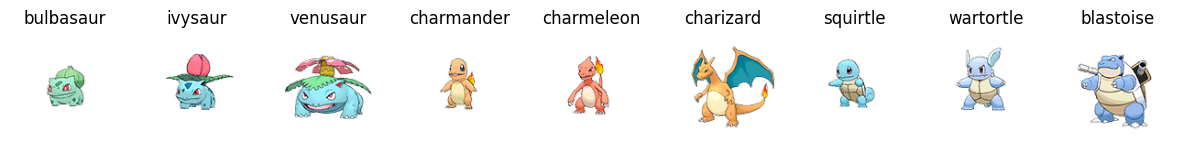

In [6]:
fig, axes = plt.subplots(1, 9, figsize=(15, 5))

for i, nom_pokemon in enumerate(df['Name'].head(9)):
    chemin_image_png = images_directory + nom_pokemon.lower() + ".png"
    chemin_image_jpg = images_directory + nom_pokemon.lower() + ".jpg"

    if os.path.exists(chemin_image_png):
        chemin_image = chemin_image_png
    elif os.path.exists(chemin_image_jpg):
        chemin_image = chemin_image_jpg
    else:
        print(f"Aucun fichier trouvé pour {nom_pokemon}")
        continue

    img = Image.open(chemin_image)

    axes[i].imshow(img)
    axes[i].set_title(nom_pokemon)
    axes[i].axis('off')

plt.show()


# Import OHE

In [7]:
df

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN
...,...,...,...
804,stakataka,Rock,Steel
805,blacephalon,Fire,Ghost
806,zeraora,Electric,NaN
807,meltan,Steel,NaN


In [8]:
df = df.copy()
df = df.fillna('')
df

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,
4,charmeleon,Fire,
...,...,...,...
804,stakataka,Rock,Steel
805,blacephalon,Fire,Ghost
806,zeraora,Electric,
807,meltan,Steel,


In [9]:
X = df['Type1']

In [10]:
# Use column transform for preprocessing only type1 and type2
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False, drop='first'), ['Type1', 'Type2'])
    ],
    remainder='passthrough'
)

In [11]:
# Use a pipelin for look perfectly the step
pipeline = Pipeline([
    ('preprocessor', preprocessor)
])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['Type1', 'Type2'])]))])

In [12]:
# Apply the ohe
df_ohe = pipeline.fit_transform(df[['Type1', 'Type2']])

/home/morgane/.pyenv/versions/3.10.6/envs/catchemall/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [13]:
feature_names_out = pipeline.named_steps['preprocessor'].named_transformers_['onehot'].get_feature_names_out(['Type1', 'Type2'])

In [14]:
onehot_df = pd.DataFrame(df_ohe, columns=feature_names_out)

In [15]:
onehot_df

,Type1_Dark,Type1_Dragon,Type1_Electric,Type1_Fairy,Type1_Fighting,Type1_Fire,Type1_Flying,Type1_Ghost,Type1_Grass,Type1_Ground,...,Type2_Ghost,Type2_Grass,Type2_Ground,Type2_Ice,Type2_Normal,Type2_Poison,Type2_Psychic,Type2_Rock,Type2_Steel,Type2_Water
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
805,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
806,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
807,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# Delet the prefixe Type_1 and Type_2 for every columns

for col in onehot_df.columns:
    if col.startswith('Type1_'):
        onehot_df.rename(columns={col: col.replace('Type1_', '')}, inplace=True)
    elif col.startswith('Type2_'):
        onehot_df.rename(columns={col: col.replace('Type2_', '')}, inplace=True)
onehot_df

,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,...,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
805,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
806,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
807,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
merged_df = onehot_df.groupby(level=0, axis=1).sum()

In [18]:
df_ohe = pd.concat([df, merged_df], axis=1)

In [19]:
df_ohe = df_ohe.drop(['Type1', 'Type2'], axis=1)

In [20]:
df_ohe

,Name,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
0,bulbasaur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,ivysaur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,venusaur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,charmander,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,charmeleon,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,stakataka,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
805,blacephalon,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
806,zeraora,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
807,meltan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Création dossiers par type de Pokémon

In [21]:
types = set(df['Type1'])
types


{'Bug',
 'Dark',
 'Dragon',
 'Electric',
 'Fairy',
 'Fighting',
 'Fire',
 'Flying',
 'Ghost',
 'Grass',
 'Ground',
 'Ice',
 'Normal',
 'Poison',
 'Psychic',
 'Rock',
 'Steel',
 'Water'}

In [22]:
parent_directory


'/home/morgane/code/mtthibault/catchemall'

In [23]:
types_directory = os.path.join(parent_directory, "raw_data/computer_vision/types/")
types_directory


'/home/morgane/code/mtthibault/catchemall/raw_data/computer_vision/types/'

In [24]:
for pokemon_type in types:
    type_directory_path = os.path.join(types_directory, pokemon_type)
    # Pour vérifier si dossier existe déjà, sinon créer
    if not os.path.exists(type_directory_path):
        os.makedirs(type_directory_path)


# Rangement des pokémons par dossier Type

In [25]:
for index, row in df.iterrows():
    pokemon_name = row['Name']
    type1 = row['Type1']
    type2 = str(row['Type2'])  # str pcq sinon ça bug à cause des NaN

    type1_directory_path = os.path.join(types_directory, type1)
    if os.path.exists(type1_directory_path):
        for ext in ['jpg', 'png']:
            source_image_path = os.path.join(images_directory, f'{pokemon_name}.{ext}')
            if os.path.exists(source_image_path):
                destination_path = os.path.join(type1_directory_path, f'{pokemon_name}.{ext}')
                shutil.copy(source_image_path, destination_path)
                break

    # Vérifier si le type 2 existe et copier l'image
    if type2:
        type2_directory_path = os.path.join(types_directory, type2)
        if os.path.exists(type2_directory_path):
            for ext in ['jpg', 'png']:
                source_image_path = os.path.join(images_directory, f'{pokemon_name}.{ext}')
                if os.path.exists(source_image_path):
                    destination_path = os.path.join(type2_directory_path, f'{pokemon_name}.{ext}')
                    shutil.copy(source_image_path, destination_path)
                    break


# Exploration 2

In [26]:
types_path = '/home/morgane/code/mtthibault/catchemall/raw_data/computer_vision/types'
types_path


'/home/morgane/code/mtthibault/catchemall/raw_data/computer_vision/types'

In [27]:
pokemon_dict = {}


In [28]:
os.listdir(types_path)


['Ghost',
 'Fighting',
 'Ground',
 'Dark',
 'Flying',
 'Normal',
 'Steel',
 'Grass',
 'Ice',
 'Rock',
 'Water',
 'Electric',
 'Psychic',
 'Bug',
 'Fairy',
 'Fire',
 'Poison',
 'Dragon']

In [29]:
for type_folder in os.listdir(types_path):
    type_folder_path = os.path.join(types_path, type_folder) #donc là j'ai le chemin pour chaqun de mes folders TYPE

    # vérifie si le chemin est un dossier
    if os.path.isdir(type_folder_path):
        pokemon_names = [] # Jstock les noms des pokémons pour le type actuel

        # parcours de chaque image dans le dossier du type actuel
        for file_name in os.listdir(type_folder_path):
            # pour gérer png jpg
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                pokemon_name = os.path.splitext(file_name)[0] #pour split l'extension .png .jpg cimer chatgpt
                pokemon_names.append(pokemon_name) #J'ajoute le nom du pokémon à la liste

        pokemon_dict[type_folder] = pokemon_names


In [30]:
pokemon_dict


{'Ghost': ['golett',
  'aegislash-blade',
  'frillish',
  'sandygast',
  'duskull',
  'golurk',
  'decidueye',
  'gengar',
  'gastly',
  'palossand',
  'gourgeist-average',
  'froslass',
  'hoopa-confined',
  'shedinja',
  'shuppet',
  'haunter',
  'yamask',
  'chandelure',
  'rotom',
  'jellicent',
  'dhelmise',
  'honedge',
  'marshadow',
  'mismagius',
  'dusclops',
  'blacephalon',
  'misdreavus',
  'trevenant',
  'litwick',
  'giratina-altered',
  'dusknoir',
  'lampent',
  'doublade',
  'banette',
  'sableye',
  'phantump',
  'pumpkaboo-average',
  'cofagrigus',
  'drifloon',
  'lunala',
  'spiritomb',
  'drifblim',
  'mimikyu'],
 'Fighting': ['hitmonchan',
  'mankey',
  'stufful',
  'infernape',
  'hariyama',
  'gurdurr',
  'pancham',
  'combusken',
  'keldeo-ordinary',
  'mienshao',
  'crabrawler',
  'pheromosa',
  'blaziken',
  'mienfoo',
  'throh',
  'hitmonlee',
  'kommo-o',
  'hawlucha',
  'pignite',
  'conkeldurr',
  'marshadow',
  'lucario',
  'timburr',
  'crabominable',

In [31]:
len(pokemon_dict['Bug'])


77

In [32]:
pokemon_names


['axew',
 'salamence',
 'guzzlord',
 'shelgon',
 'goodra',
 'dragonite',
 'haxorus',
 'kingdra',
 'druddigon',
 'goomy',
 'vibrava',
 'sliggoo',
 'flygon',
 'zekrom',
 'tyrunt',
 'drampa',
 'noibat',
 'dragonair',
 'dialga',
 'gible',
 'noivern',
 'kommo-o',
 'gabite',
 'zweilous',
 'jangmo-o',
 'naganadel',
 'latias',
 'hydreigon',
 'fraxure',
 'latios',
 'rayquaza',
 'hakamo-o',
 'deino',
 'kyurem',
 'dragalge',
 'giratina-altered',
 'dratini',
 'reshiram',
 'altaria',
 'palkia',
 'tyrantrum',
 'zygarde-50',
 'turtonator',
 'garchomp',
 'bagon']

Type: Ghost


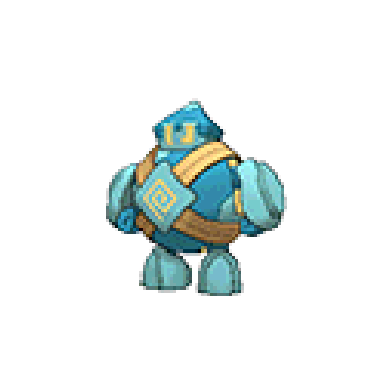

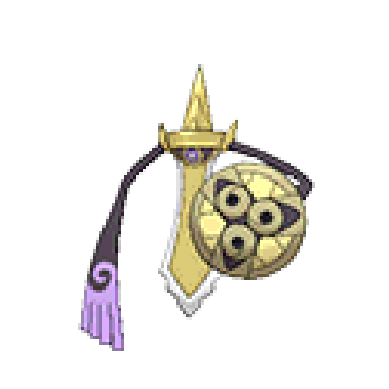

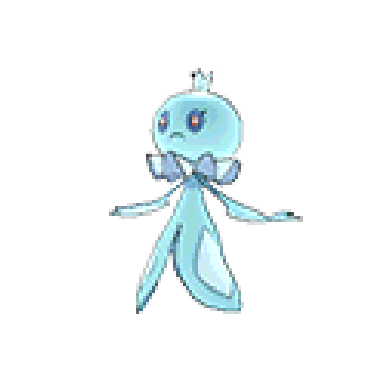



Type: Fighting


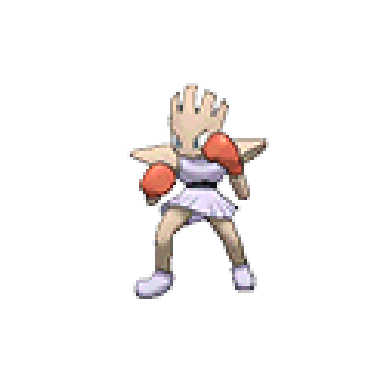

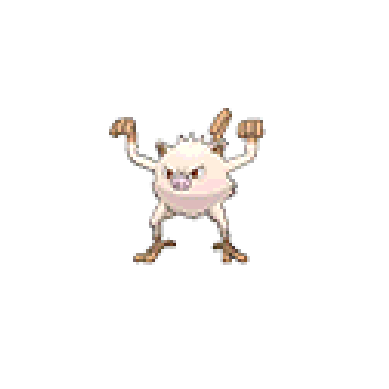

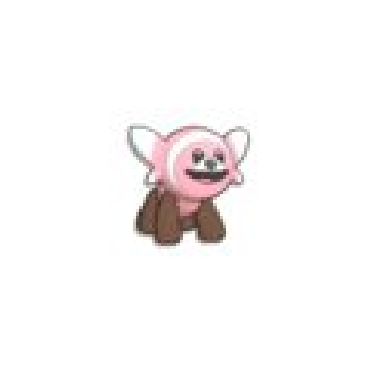



Type: Ground


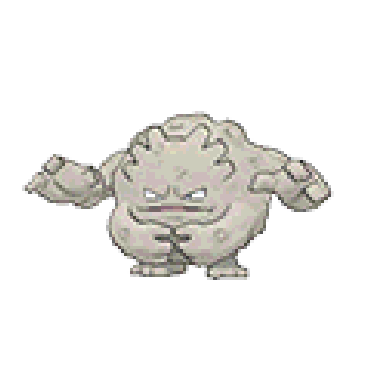

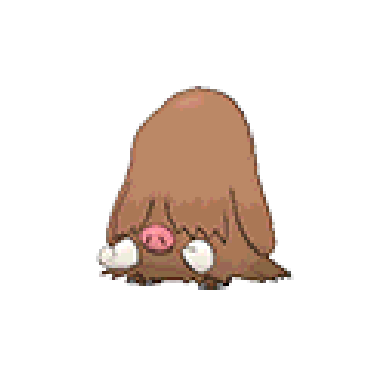

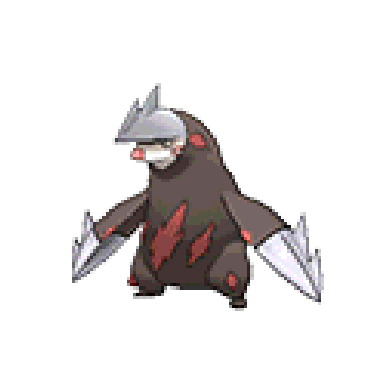



Type: Dark


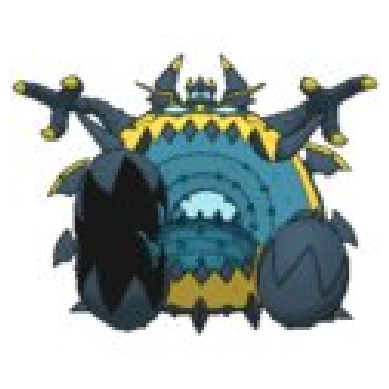

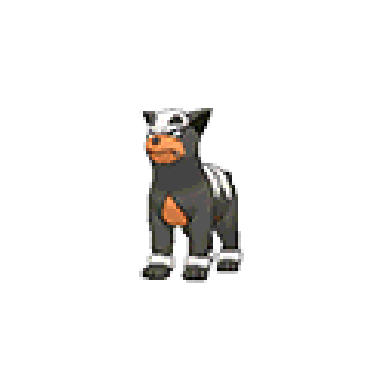

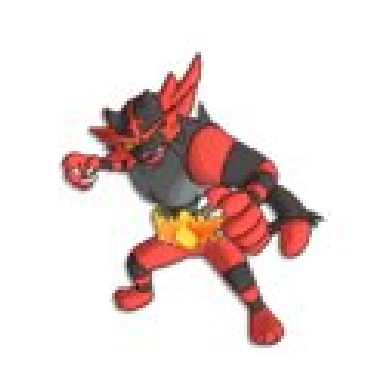



Type: Flying


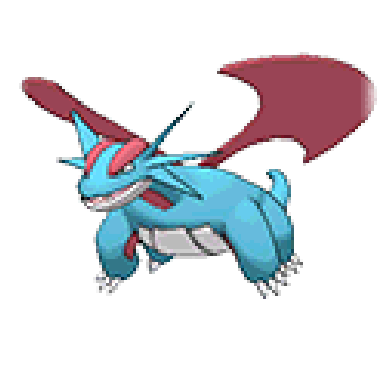

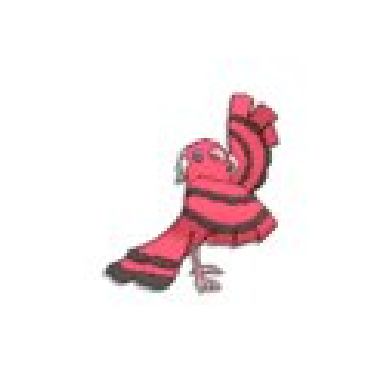

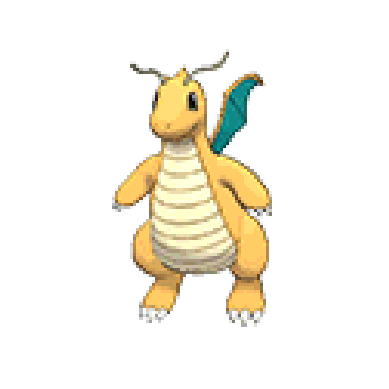



Type: Normal


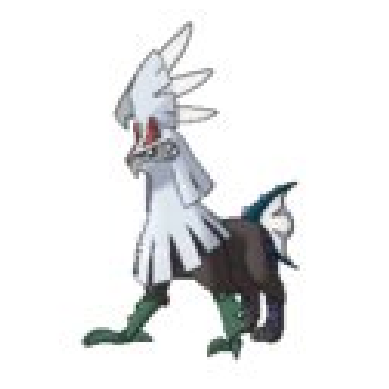

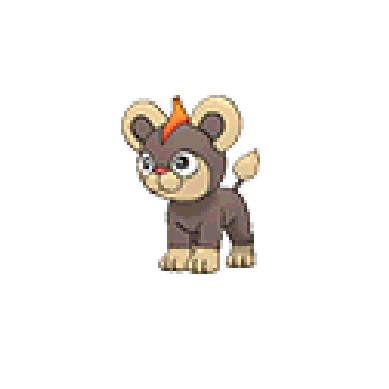

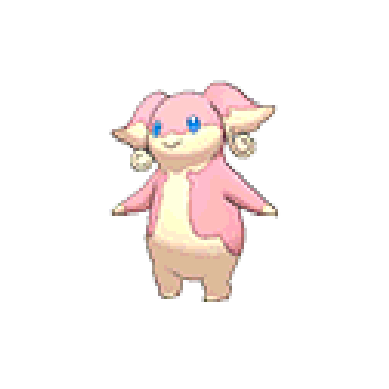



Type: Steel


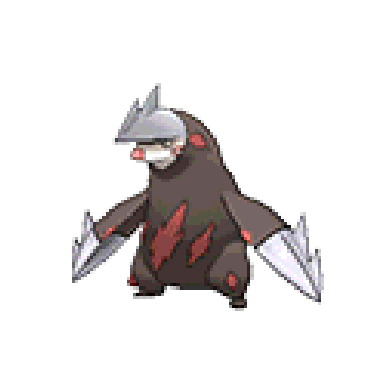

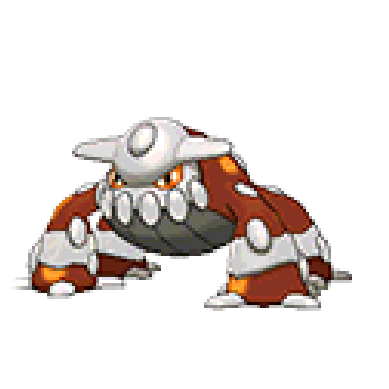

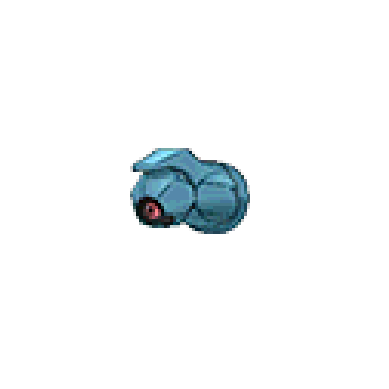



Type: Grass


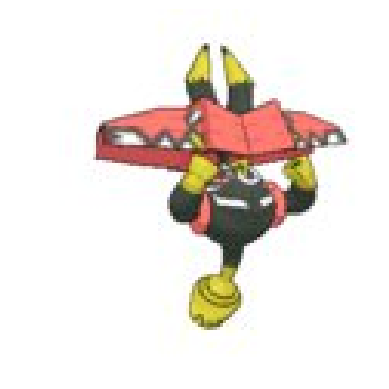

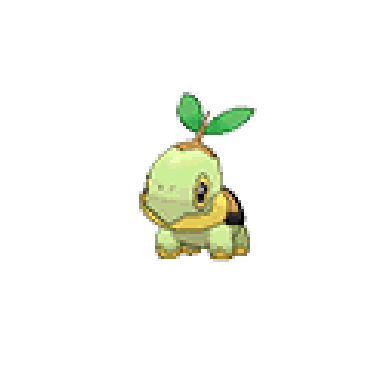

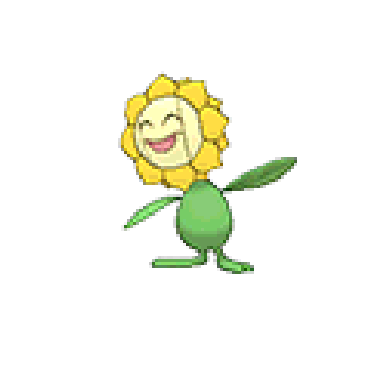



Type: Ice


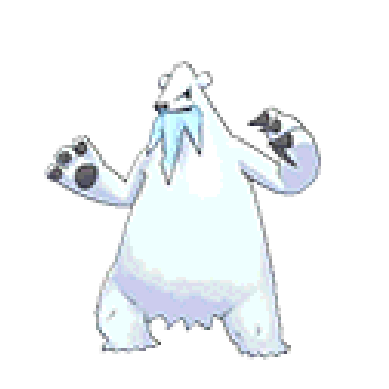

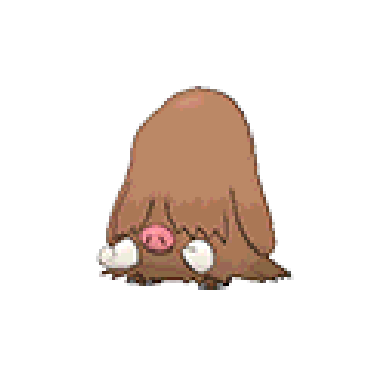

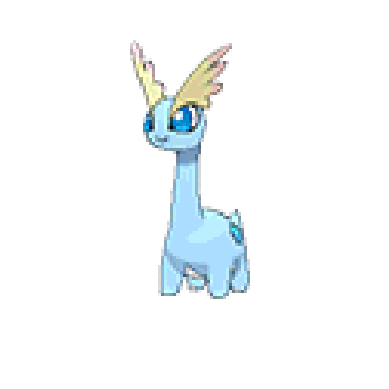



Type: Rock


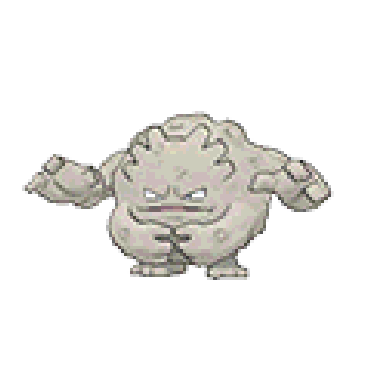

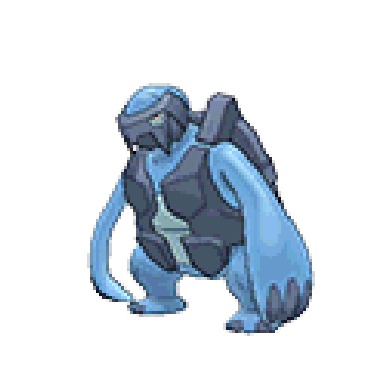

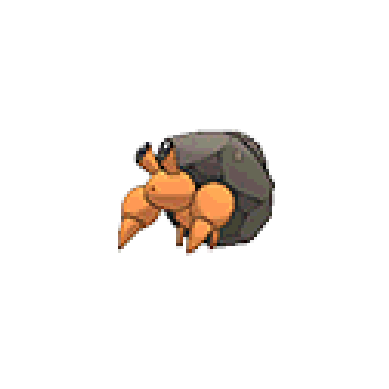



Type: Water


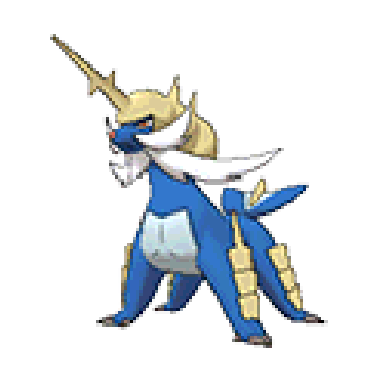

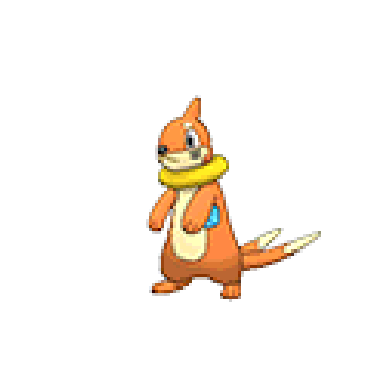

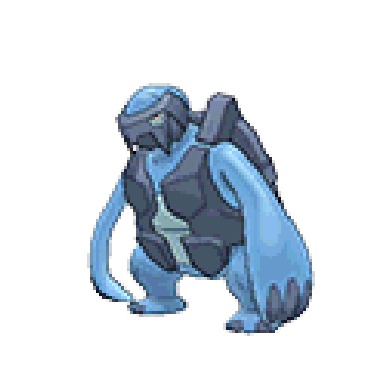



Type: Electric


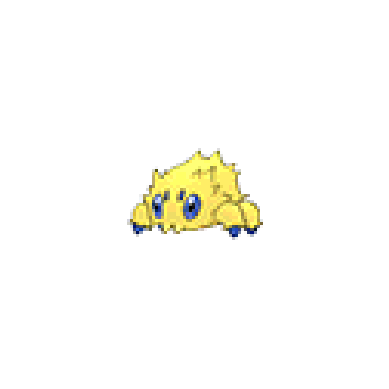

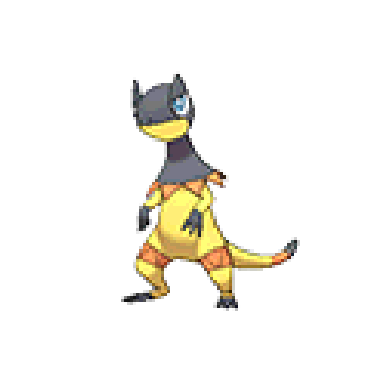

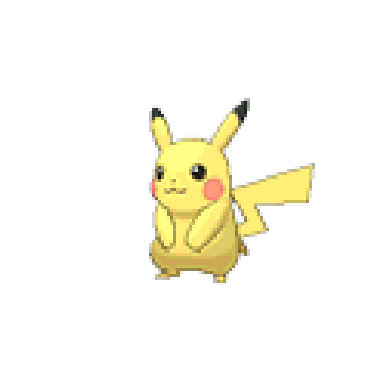



Type: Psychic


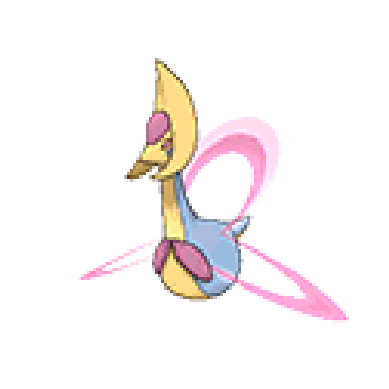

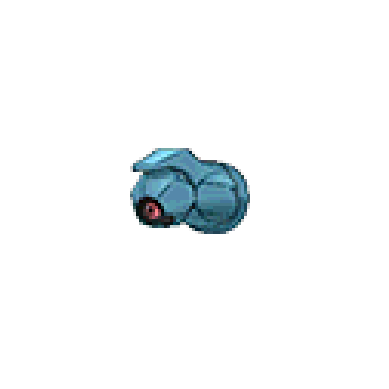

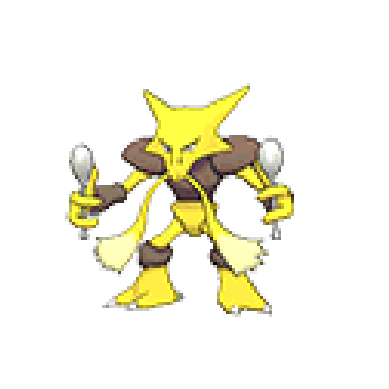



Type: Bug


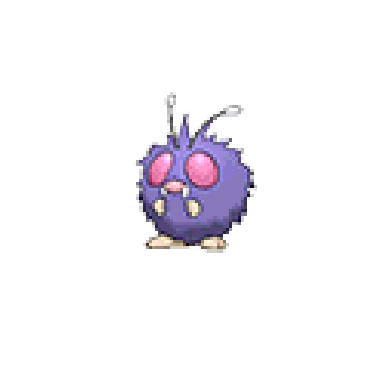

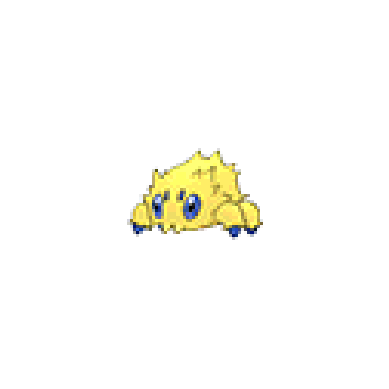

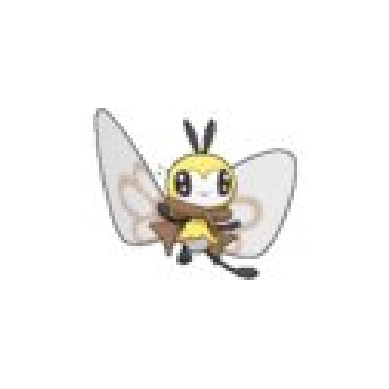



Type: Fairy


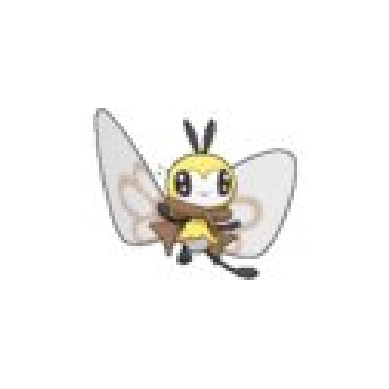

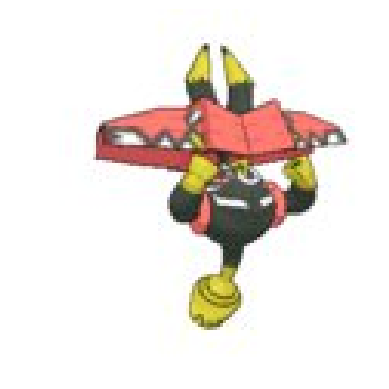

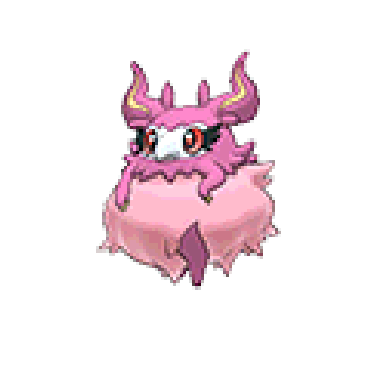



Type: Fire


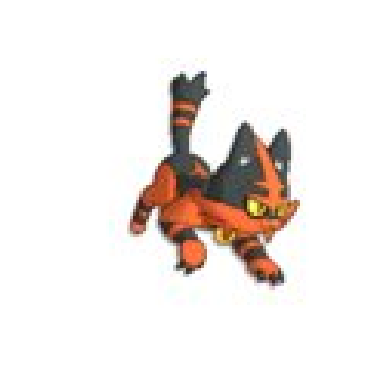

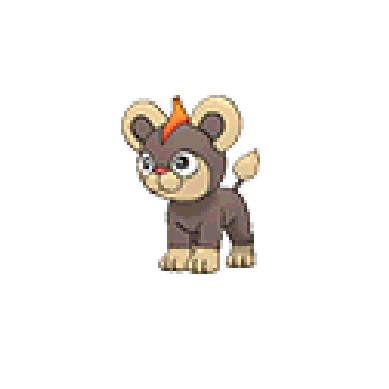

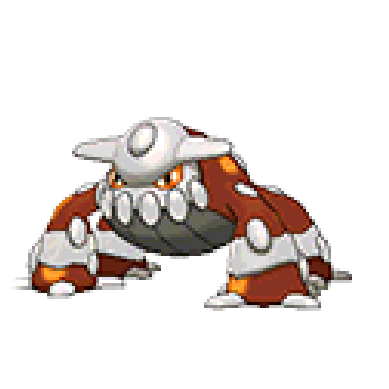



Type: Poison


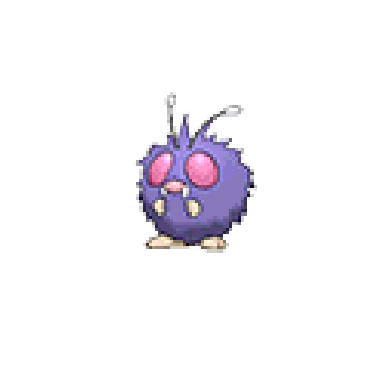

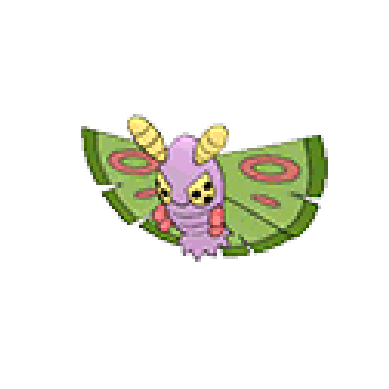

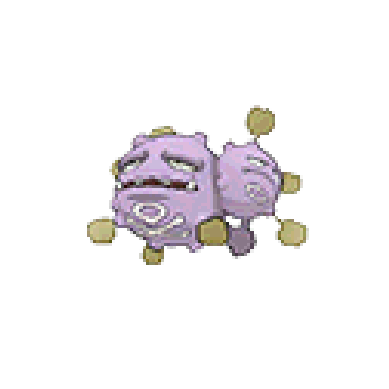



Type: Dragon


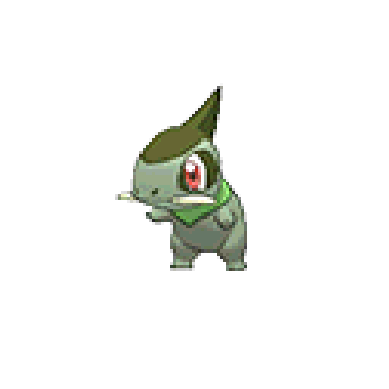

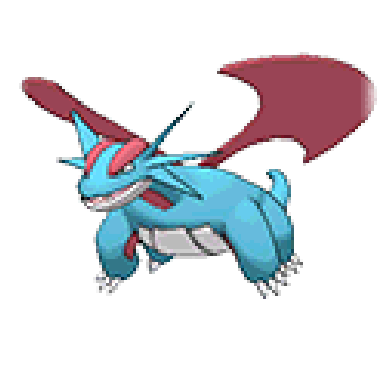

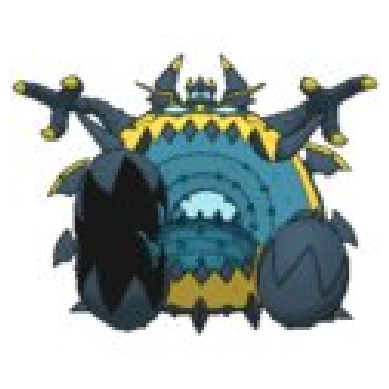

In [33]:
num_images_to_display = 3

for pokemon_type, pokemon_names in pokemon_dict.items():
    print(f"Type: {pokemon_type}")
    
    for name in pokemon_names[:num_images_to_display]:
        for extension in ['.jpg', '.jpeg', '.png']:
            image_path = os.path.join(types_path, pokemon_type, f"{name}{extension}")
            
            if os.path.exists(image_path):
                img = imread(image_path)
                plt.imshow(img)
                plt.axis('off')
                plt.show()
                break
    
    print("\n")

Type: Ghost


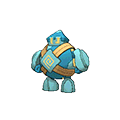

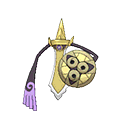

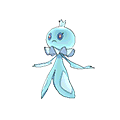



Type: Fighting


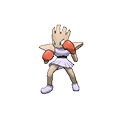

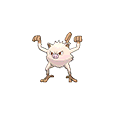

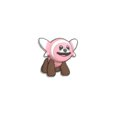



Type: Ground


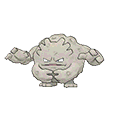

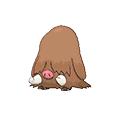

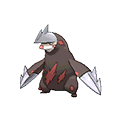



Type: Dark


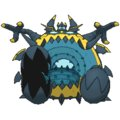

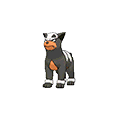

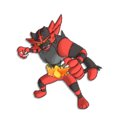



Type: Flying


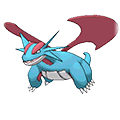

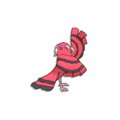

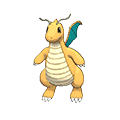



Type: Normal


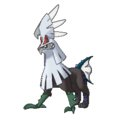

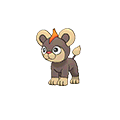

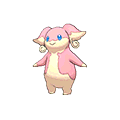



Type: Steel


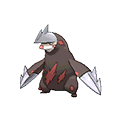

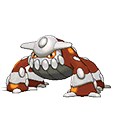

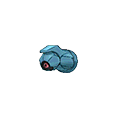



Type: Grass


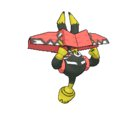

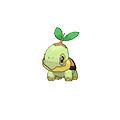

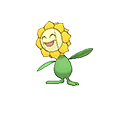



Type: Ice


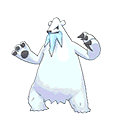

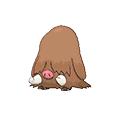

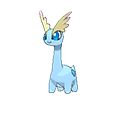



Type: Rock


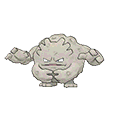

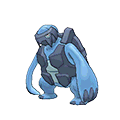

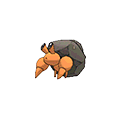



Type: Water


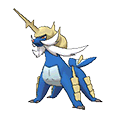

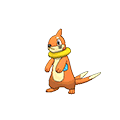

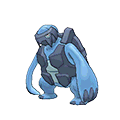



Type: Electric


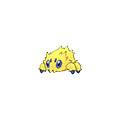

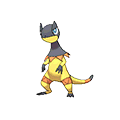

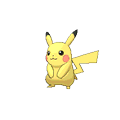



Type: Psychic


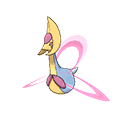

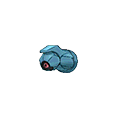

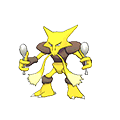



Type: Bug


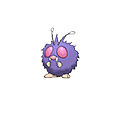

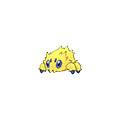

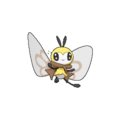



Type: Fairy


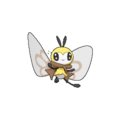

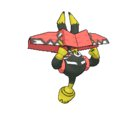

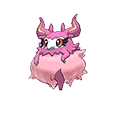



Type: Fire


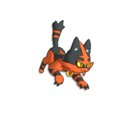

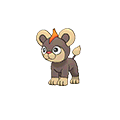

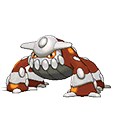



Type: Poison


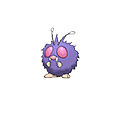

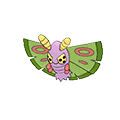

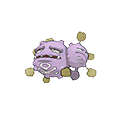



Type: Dragon


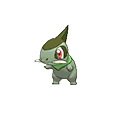

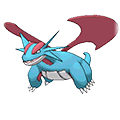

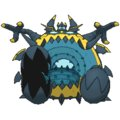

In [34]:
num_images_to_display = 3

for pokemon_type, pokemon_names in pokemon_dict.items():
    print(f"Type: {pokemon_type}")
    
    for name in pokemon_names[:num_images_to_display]:
        for extension in ['.jpg', '.jpeg', '.png']:
            image_path = os.path.join(types_path, pokemon_type, f"{name}{extension}")
            
            if os.path.exists(image_path):
                display(IPImage(filename=image_path))
                break
    
    print("\n")

# Analyse

In [35]:
y = list(df['Type1'].unique())
y

['Grass',
 'Fire',
 'Water',
 'Bug',
 'Normal',
 'Poison',
 'Electric',
 'Ground',
 'Fairy',
 'Fighting',
 'Psychic',
 'Rock',
 'Ghost',
 'Ice',
 'Dragon',
 'Dark',
 'Steel',
 'Flying']

In [36]:
types_path

'/home/morgane/code/mtthibault/catchemall/raw_data/computer_vision/types'

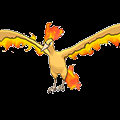

In [37]:
img = load_img(f"{types_path}/Fire/moltres.png")
img

In [38]:
x = img_to_array(img)
x

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [39]:
x.shape

(120, 120, 3)

# CNN

In [44]:
train_data_dir = parent_directory + "/raw_data/computer_vision/train_test/train/"
test_data_dir = parent_directory + "/raw_data/computer_vision/train_test/test/"
print(train_data_dir)
print(test_data_dir)

/home/morgane/code/mtthibault/catchemall/raw_data/computer_vision/train_test/train/
/home/morgane/code/mtthibault/catchemall/raw_data/computer_vision/train_test/test/


In [45]:
train_ds = image_dataset_from_directory(train_data_dir,
                                        labels="inferred",
                                        label_mode="categorical",
                                        image_size=(120,120),
                                        batch_size=32,
                                        seed=123)

train_ds

Found 964 files belonging to 18 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None))>

In [46]:
val_ds = image_dataset_from_directory(test_data_dir,
                                      labels="inferred",
                                      label_mode="categorical",
                                      image_size=(120,120),
                                      batch_size=32,
                                      seed=123)

val_ds

Found 250 files belonging to 18 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None))>

In [48]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    
    # LOSS
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[0].legend()
    ax[0].grid()
    
    # ACCURACY
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[1].legend()
    ax[1].grid()

In [49]:
def plot_loss_accuracy(history):

    fig, ax = plt.subplots(1, 2, figsize=(15, 4))

    ## Plot Losses and Accuracies
    x_axis = np.arange(len(history.history['loss']))

    ax[0].set_title("Loss")
    ax[0].plot(x_axis, history.history['loss'], color="blue", linestyle=":", marker="X", label="Train Loss")
    ax[0].plot(x_axis, history.history['val_loss'], color="orange", linestyle="-", marker="X", label="Val Loss")

    ax[1].set_title("Accuracy")
    ax[1].plot(x_axis, history.history['accuracy'], color="blue", linestyle=":", marker="X", label="Train Accuracy")
    ax[1].plot(x_axis,
               history.history['val_accuracy'],
               color="orange",
               linestyle="-",
               marker="X",
               label="Val Accuracy")

    ## Customization
    ax[0].grid(axis="x", linewidth=0.5)
    ax[0].grid(axis="y", linewidth=0.5)
    ax[0].legend()

    ax[1].grid(axis="x", linewidth=0.5)
    ax[1].grid(axis="y", linewidth=0.5)
    ax[1].legend()


    plt.show()

## CNN - Bazar

### V1 - First Model (Sequential)

In [40]:
#adam_opt = optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)

In [41]:
def first_model():
    
    ##########################
    # 1 - Architecture       #
    ##########################
    
    # Instantiate the Sequential model
    model = models.Sequential()
    
    # Rescaling layer
    model.add(layers.Rescaling(1./255, input_shape=(120,120,3)))
    
    # Convolutional Layers
    model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding = "same")) #pour spatial data (images)
    model.add(layers.MaxPooling2D(pool_size=(2,2), padding = "same")) #goodpractice askip
    
    model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding = "same")) #pour spatial data (images)
    model.add(layers.MaxPooling2D(pool_size=(2,2), padding = "same")) #goodpractice askip

    model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding = "same")) #pour spatial data (images)
    model.add(layers.MaxPooling2D(pool_size=(2,2), padding = "same")) #goodpractice askip

    model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding = "same")) #pour spatial data (images)
    model.add(layers.MaxPooling2D(pool_size=(2,2), padding = "same")) #goodpractice askip
              
    model.add(layers.Flatten()) #pour passer de convolutional à dense layers         
              
    # Hidden Dense Layers
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(rate=0.5))  #pour régulariser modèle et éviter overfitting => potentiellement à ajuster       
    
    # Predictive layer
    model.add(layers.Dense(18, activation="softmax")) #softmax pcq 18 classes (sigmoid = binaire)
    
    ##########################
    # 2 - Compile            #
    ##########################
    
    model.compile(loss="categorical_crossentropy", #pcq plsrs valeurs qui sont OHE, sinon pour les entiers => sparse_categorical_crossentropy
                  optimizer="adam",
                  metrics = ["accuracy"])
    
    return model

In [42]:
first_model = first_model()
first_model.summary()

2023-12-06 14:57:47.539089: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-06 14:57:47.539377: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 120, 120, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 120, 120, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        1

In [47]:
MODEL = "first_model"

# modelCheckpoint = callbacks.ModelCheckpoint("{}.h5".format(MODEL), 
#                                             monitor="val_loss",
#                                             save_best_only = True)

# LR_reducer = callbacks.ReduceLROnPlateau(patience = 3,
#                                          monitor="val_loss",
#                                          factor = 0.1,
#                                          min_lr = 0 
#                                         )

early_stopper = callbacks.EarlyStopping(patience = 10,
                                        monitor="val_loss",
                                        restore_best_weights=True)

history = first_model.fit(train_ds,
                          validation_data = val_ds,
                          epochs = 30,
                          callbacks = [early_stopper])

Epoch 1/30
31/31 [==============================] - 2s 51ms/step - loss: 2.8861 - accuracy: 0.0923 - val_loss: 2.8677 - val_accuracy: 0.1040
Epoch 2/30
31/31 [==============================] - 1s 48ms/step - loss: 2.8598 - accuracy: 0.0975 - val_loss: 2.8428 - val_accuracy: 0.0960
Epoch 3/30
31/31 [==============================] - 1s 47ms/step - loss: 2.8574 - accuracy: 0.1037 - val_loss: 2.8132 - val_accuracy: 0.1160
Epoch 4/30
31/31 [==============================] - 1s 47ms/step - loss: 2.8200 - accuracy: 0.1255 - val_loss: 2.7681 - val_accuracy: 0.1200
Epoch 5/30
31/31 [==============================] - 1s 46ms/step - loss: 2.8117 - accuracy: 0.1359 - val_loss: 2.7336 - val_accuracy: 0.1320
Epoch 6/30
31/31 [==============================] - 1s 47ms/step - loss: 2.7892 - accuracy: 0.1297 - val_loss: 2.7443 - val_accuracy: 0.1600
Epoch 7/30
31/31 [==============================] - 1s 46ms/step - loss: 2.7541 - accuracy: 0.1452 - val_loss: 2.7384 - val_accuracy: 0.1400
Epoch 8/30
31

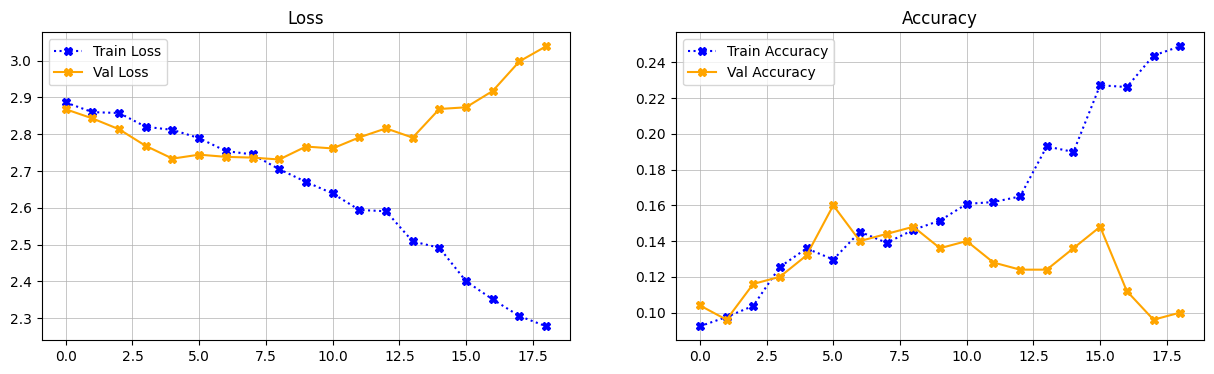

In [50]:
plot_loss_accuracy(history)

### V2 - Second Model (VGG16)

In [59]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [60]:
data_augmentation = models.Sequential()
data_augmentation.add(layers.RandomFlip("horizontal"))
data_augmentation.add(layers.RandomZoom((0.1, 0.2)))
data_augmentation.add(layers.RandomTranslation(0.2, 0.2))
data_augmentation.add(layers.RandomRotation(0.1))

In [61]:
vgg16 = VGG16(weights = "imagenet", 
              include_top = False, # Exclude Hidden Dense Layers + Predictive Dense Layer
              input_shape = (120, 120, 3))

vgg16.trainable = False

vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 120, 120, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 120, 120, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 60, 60, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 60, 60, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 60, 60, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 30, 30, 128)       0     

In [62]:
my_dense_layers = models.Sequential()
# Hidden Dense Layers
my_dense_layers.add(layers.Dense(64, activation="relu"))
my_dense_layers.add(layers.Dropout(rate=0.5))         
    
# Predictive layer
predictive_layer = layers.Dense(18, activation="softmax")

In [63]:
#################################
# 1= ARCHITECTURE               #
#################################

from tensorflow.keras.models import Model

inputs = layers.Input(shape = (120, 120, 3))

# # Pour resize
# resized_inputs = tf.image.resize(inputs, size=(150, 150))

x = data_augmentation(inputs) # We still have our data augmentation layers
x = preprocess_input(x) # Then a preprocessing layer specifically designed for the VGG16
x = vgg16(x) # Then our transfer learning model

x = layers.Flatten()(x) # Followed by our custom dense layers, tailored to our binary task

x = layers.Dense(128, activation = "relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation = "relu")(x)
x = layers.Dropout(0.3)(x)
pred = layers.Dense(18, activation = "softmax")(x)

# We use the keras Functional API to create our Keras model

model_2 = Model(inputs = inputs , outputs = pred)

second_model = Model(inputs = inputs, outputs = pred )

#################################
# 2= COMPILE                    #
#################################

second_model.compile(loss="categorical_crossentropy",
                    optimizer = "adam",
                    metrics = ["accuracy"])

second_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 120, 120, 3)       0         
                                                                 
 tf.__operators__.getitem_1  (None, 120, 120, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 120, 120, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 4608)              0   

In [64]:
MODEL = "second_model"

# third_modelCheckpoint = callbacks.ModelCheckpoint("{}.h5".format(MODEL), 
#                                             monitor="val_loss",
#                                             save_best_only = True)

# third_LR_reducer = callbacks.ReduceLROnPlateau(patience = 3,
#                                          monitor="val_loss",
#                                          factor = 0.1,
#                                          min_lr = 0 
#                                         )

second_early_stopper = callbacks.EarlyStopping(patience = 10,
                                        monitor="val_loss",
                                        restore_best_weights=True)

second_history = second_model.fit(train_ds,
                          validation_data = val_ds,
                          epochs = 30,
                          callbacks = [second_early_stopper])

Epoch 1/30
31/31 [==============================] - 13s 399ms/step - loss: 7.9263 - accuracy: 0.0602 - val_loss: 3.7730 - val_accuracy: 0.0760
Epoch 2/30
31/31 [==============================] - 12s 384ms/step - loss: 3.7718 - accuracy: 0.0757 - val_loss: 3.2144 - val_accuracy: 0.0640
Epoch 3/30
31/31 [==============================] - 12s 385ms/step - loss: 3.1224 - accuracy: 0.0840 - val_loss: 3.0168 - val_accuracy: 0.0720
Epoch 4/30
31/31 [==============================] - 12s 386ms/step - loss: 2.9928 - accuracy: 0.1172 - val_loss: 2.9233 - val_accuracy: 0.1080
Epoch 5/30
31/31 [==============================] - 12s 390ms/step - loss: 2.9541 - accuracy: 0.1079 - val_loss: 2.9707 - val_accuracy: 0.1080
Epoch 6/30
31/31 [==============================] - 12s 388ms/step - loss: 2.8753 - accuracy: 0.1203 - val_loss: 2.9623 - val_accuracy: 0.1080
Epoch 7/30
31/31 [==============================] - 12s 389ms/step - loss: 2.9415 - accuracy: 0.1068 - val_loss: 2.8824 - val_accuracy: 0.1120

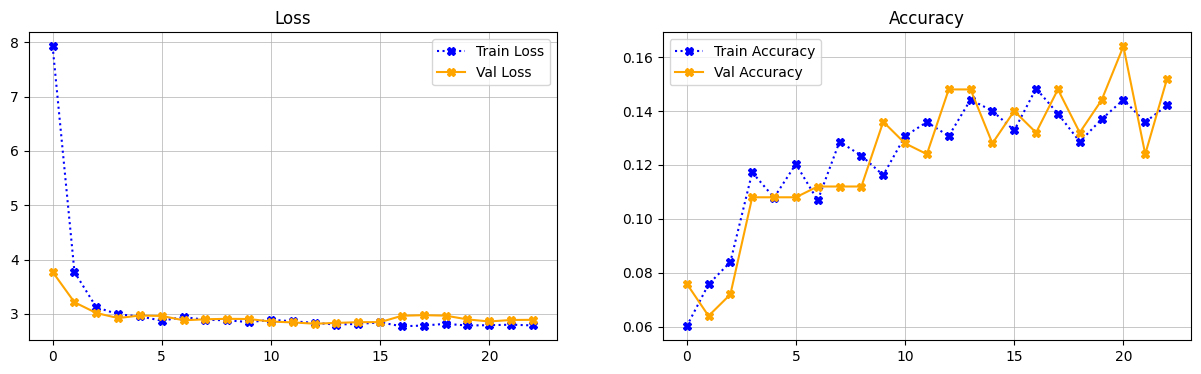

In [65]:
plot_loss_accuracy(second_history)

### V3 - Troisième Model (VGG16)

In [76]:
data_augmentation = models.Sequential()
data_augmentation.add(layers.RandomFlip("horizontal"))
data_augmentation.add(layers.RandomZoom((0.1, 0.2)))
data_augmentation.add(layers.RandomTranslation(0.2, 0.2))
data_augmentation.add(layers.RandomRotation(0.1))

vgg16 = VGG16(weights = "imagenet", 
              include_top = False, # Exclude Hidden Dense Layers + Predictive Dense Layer
              input_shape = (120, 120, 3))

vgg16.trainable = False

my_dense_layers = models.Sequential()

my_dense_layers.add(layers.Dense(64, activation="relu"))
my_dense_layers.add(layers.Dropout(rate=0.5))         
    

predictive_layer = layers.Dense(18, activation="softmax")

In [77]:
#################################
# 1= ARCHITECTURE               #
#################################

from tensorflow.keras.models import Model

inputs = layers.Input(shape = (120, 120, 3))

# # Pour resize
# resized_inputs = tf.image.resize(inputs, size=(150, 150))

x = data_augmentation(inputs) # We still have our data augmentation layers
x = preprocess_input(x) # Then a preprocessing layer specifically designed for the VGG16
x = vgg16(x) # Then our transfer learning model

x = layers.Flatten()(x) # Followed by our custom dense layers, tailored to our binary task

x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.3)(x)

# Batch Normalization
x = layers.BatchNormalization()(x)

# Predictive layer
pred = layers.Dense(18, activation="softmax")(x)

model_2 = models.Model(inputs=inputs, outputs=pred)

# Learning Rate Scheduler
lr_scheduler = callbacks.LearningRateScheduler(lambda epoch: 0.001 * 0.95 ** epoch)

model_2.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

second_early_stopper = callbacks.EarlyStopping(
    patience=10,
    monitor="val_loss",
    restore_best_weights=True
)

second_history = model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[second_early_stopper, lr_scheduler]
)

Epoch 1/30
31/31 [==============================] - 13s 391ms/step - loss: 3.4573 - accuracy: 0.0674 - val_loss: 3.9219 - val_accuracy: 0.1440 - lr: 0.0010
Epoch 2/30
31/31 [==============================] - 12s 382ms/step - loss: 3.2710 - accuracy: 0.0654 - val_loss: 3.1785 - val_accuracy: 0.1120 - lr: 9.5000e-04
Epoch 3/30
31/31 [==============================] - 12s 384ms/step - loss: 3.2600 - accuracy: 0.0809 - val_loss: 3.1218 - val_accuracy: 0.0760 - lr: 9.0250e-04
Epoch 4/30
31/31 [==============================] - 12s 384ms/step - loss: 3.1316 - accuracy: 0.1027 - val_loss: 3.0259 - val_accuracy: 0.1000 - lr: 8.5737e-04
Epoch 5/30
31/31 [==============================] - 12s 387ms/step - loss: 3.1135 - accuracy: 0.0871 - val_loss: 2.9552 - val_accuracy: 0.0920 - lr: 8.1451e-04
Epoch 6/30
31/31 [==============================] - 12s 386ms/step - loss: 3.0193 - accuracy: 0.0965 - val_loss: 2.9564 - val_accuracy: 0.0920 - lr: 7.7378e-04
Epoch 7/30
31/31 [==========================

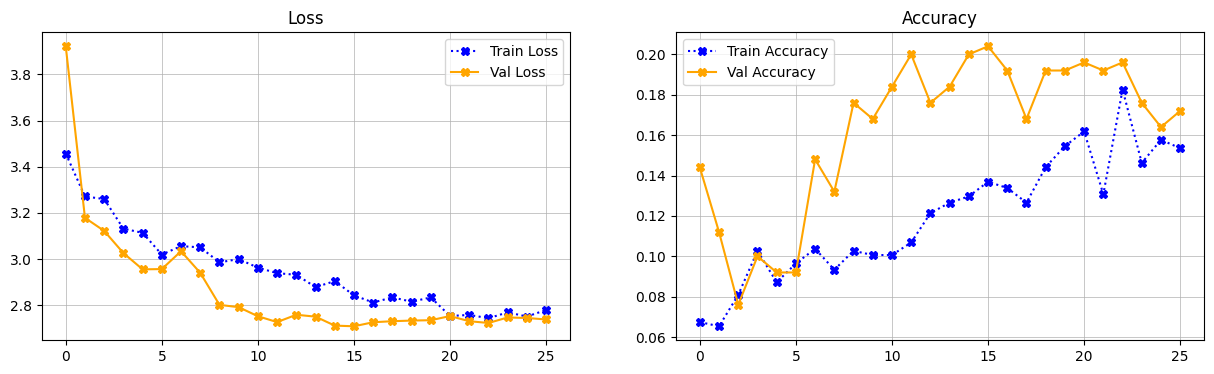

In [78]:
plot_loss_accuracy(second_history)

### V4 - Quatrième Model (EfficientNetB0)

In [79]:
from tensorflow.keras.applications import EfficientNetB0

data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomRotation(0.1),
])

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

base_model.trainable = False

model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(18, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)


16705208/16705208 [==============================] - 8s 0us/step
Epoch 1/30
31/31 [==============================] - 9s 153ms/step - loss: 2.9294 - accuracy: 0.1100 - val_loss: 2.7706 - val_accuracy: 0.1320
Epoch 2/30
31/31 [==============================] - 4s 125ms/step - loss: 2.6761 - accuracy: 0.1712 - val_loss: 2.6984 - val_accuracy: 0.1640
Epoch 3/30
31/31 [==============================] - 4s 124ms/step - loss: 2.5237 - accuracy: 0.2189 - val_loss: 2.6812 - val_accuracy: 0.1440
Epoch 4/30
31/31 [==============================] - 4s 122ms/step - loss: 2.4369 - accuracy: 0.2241 - val_loss: 2.6709 - val_accuracy: 0.1680
Epoch 5/30
31/31 [==============================] - 4s 122ms/step - loss: 2.3042 - accuracy: 0.2790 - val_loss: 2.7074 - val_accuracy: 0.1760
Epoch 6/30
31/31 [==============================] - 4s 121ms/step - loss: 2.2982 - accuracy: 0.2759 - val_loss: 2.7538 - val_accuracy: 0.1480
Epoch 7/30
31/31 [==============================] - 4s 121ms/step - loss: 2.2418 - 

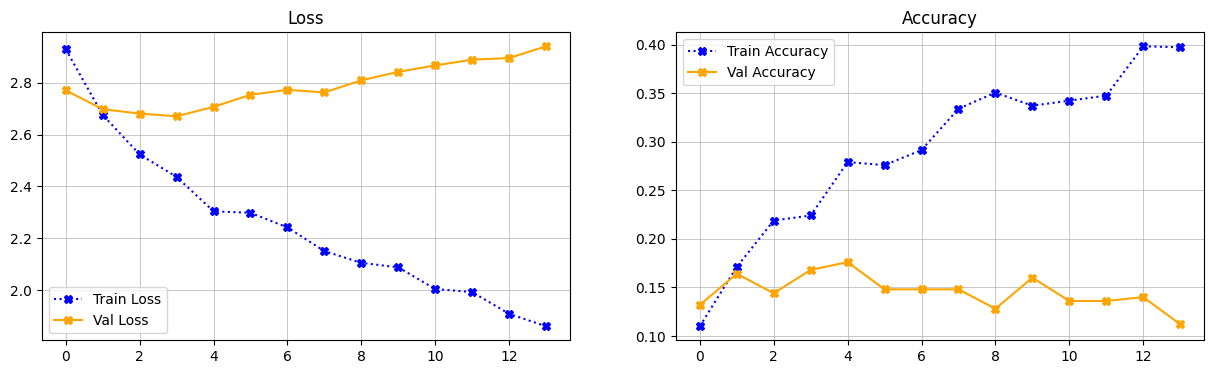

In [80]:
plot_loss_accuracy(history)

### V5 - ResNet

In [92]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, callbacks

data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomRotation(0.1),
])

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

base_model.trainable = False

model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(18, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

Epoch 1/30
31/31 [==============================] - 10s 246ms/step - loss: 3.2815 - accuracy: 0.0923 - val_loss: 2.8017 - val_accuracy: 0.1400
Epoch 2/30
31/31 [==============================] - 7s 226ms/step - loss: 2.7707 - accuracy: 0.1286 - val_loss: 2.7567 - val_accuracy: 0.1800
Epoch 3/30
31/31 [==============================] - 7s 225ms/step - loss: 2.6901 - accuracy: 0.1805 - val_loss: 2.7637 - val_accuracy: 0.1880
Epoch 4/30
31/31 [==============================] - 7s 225ms/step - loss: 2.6275 - accuracy: 0.1774 - val_loss: 2.7040 - val_accuracy: 0.1600
Epoch 5/30
31/31 [==============================] - 7s 224ms/step - loss: 2.5819 - accuracy: 0.1971 - val_loss: 2.7042 - val_accuracy: 0.2040
Epoch 6/30
31/31 [==============================] - 7s 224ms/step - loss: 2.4908 - accuracy: 0.2303 - val_loss: 2.7200 - val_accuracy: 0.1920
Epoch 7/30
31/31 [==============================] - 7s 225ms/step - loss: 2.4753 - accuracy: 0.2189 - val_loss: 2.6816 - val_accuracy: 0.1920
Epoch

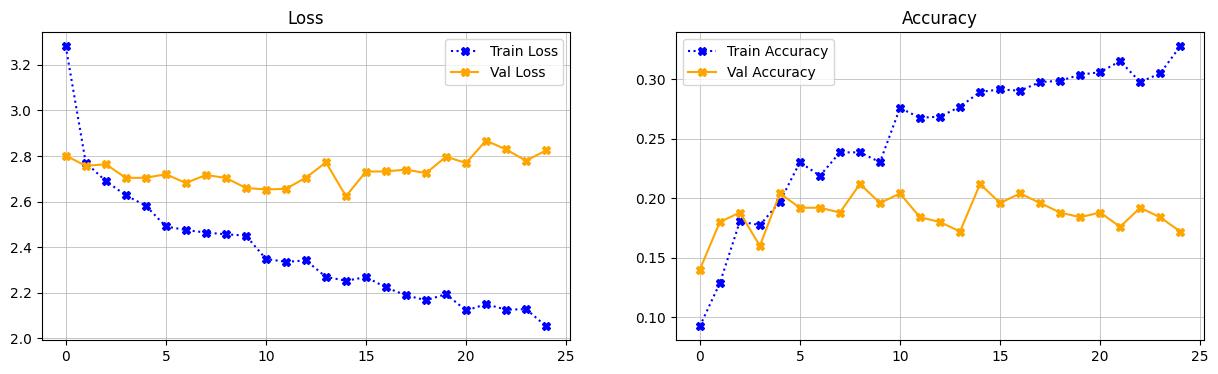

In [93]:
plot_loss_accuracy(history)

### V6 - DenseNet

In [82]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, callbacks

# Define data augmentation
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomRotation(0.1),
])

# Load DenseNet121 pre-trained on ImageNet
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

# Freeze the pre-trained layers
base_model.trainable = False

# Create a new model
model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(18, activation='softmax')
])

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Create callbacks (e.g., early stopping, learning rate scheduler)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)


29084464/29084464 [==============================] - 9s 0us/step
Epoch 1/30
31/31 [==============================] - 12s 273ms/step - loss: 12.6122 - accuracy: 0.0788 - val_loss: 3.7420 - val_accuracy: 0.0880
Epoch 2/30
31/31 [==============================] - 7s 236ms/step - loss: 3.0297 - accuracy: 0.0861 - val_loss: 2.9957 - val_accuracy: 0.1280
Epoch 3/30
31/31 [==============================] - 7s 238ms/step - loss: 2.8768 - accuracy: 0.0996 - val_loss: 2.9653 - val_accuracy: 0.1200
Epoch 4/30
31/31 [==============================] - 7s 234ms/step - loss: 2.8750 - accuracy: 0.1110 - val_loss: 2.9822 - val_accuracy: 0.0840
Epoch 5/30
31/31 [==============================] - 7s 236ms/step - loss: 2.8813 - accuracy: 0.1141 - val_loss: 2.8830 - val_accuracy: 0.0960
Epoch 6/30
31/31 [==============================] - 7s 233ms/step - loss: 2.8670 - accuracy: 0.1172 - val_loss: 2.9222 - val_accuracy: 0.0760
Epoch 7/30
31/31 [==============================] - 7s 233ms/step - loss: 2.8866 

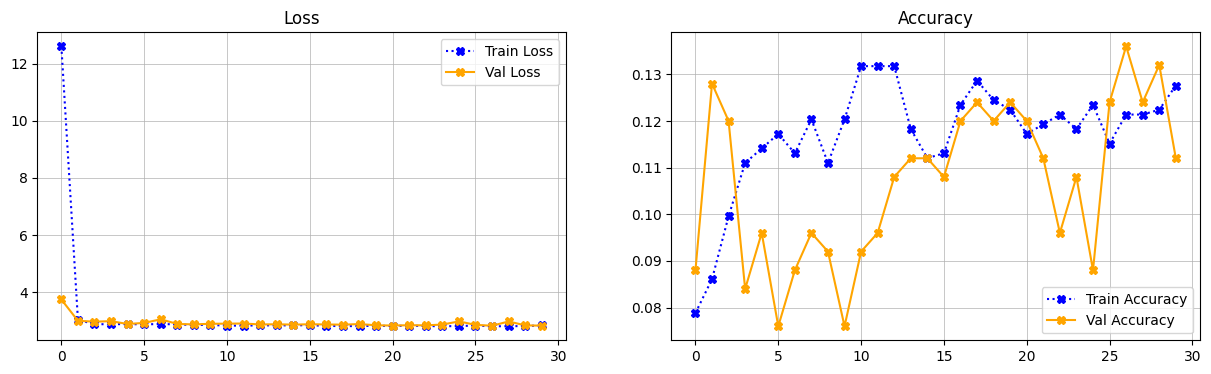

In [83]:
plot_loss_accuracy(history)

## CNN - Tentatives + sérieuses

### V1 - ResNet 1.1 (Data Augmentation)

In [88]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, callbacks

data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomRotation(0.1),
])

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(120, 120, 3))
base_model.trainable = False

model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),  # Adjusted dropout rate
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),  # Adjusted dropout rate
    layers.Dense(18, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    callbacks=[callbacks.EarlyStopping(patience=20, restore_best_weights=True)]
)


Epoch 1/200
31/31 [==============================] - 10s 247ms/step - loss: 3.5748 - accuracy: 0.0965 - val_loss: 3.9051 - val_accuracy: 0.0960
Epoch 2/200
31/31 [==============================] - 7s 216ms/step - loss: 3.1147 - accuracy: 0.1369 - val_loss: 4.0272 - val_accuracy: 0.1400
Epoch 3/200
31/31 [==============================] - 7s 216ms/step - loss: 2.9651 - accuracy: 0.1494 - val_loss: 3.9428 - val_accuracy: 0.0880
Epoch 4/200
31/31 [==============================] - 7s 215ms/step - loss: 2.7893 - accuracy: 0.1795 - val_loss: 3.4986 - val_accuracy: 0.1640
Epoch 5/200
31/31 [==============================] - 7s 215ms/step - loss: 2.7197 - accuracy: 0.2085 - val_loss: 3.4911 - val_accuracy: 0.1360
Epoch 6/200
31/31 [==============================] - 7s 214ms/step - loss: 2.6440 - accuracy: 0.2012 - val_loss: 3.6932 - val_accuracy: 0.1360
Epoch 7/200
31/31 [==============================] - 7s 214ms/step - loss: 2.6259 - accuracy: 0.2044 - val_loss: 3.3598 - val_accuracy: 0.160

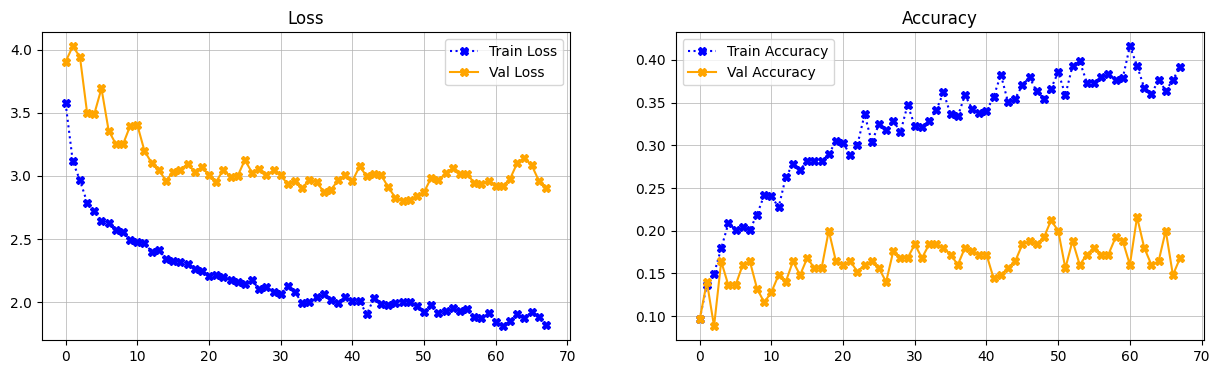

In [89]:
plot_loss_accuracy(history)

### V1 - ResNet 1.2 (Increased dropout pour réduire overfitting)

In [101]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import layers, models, callbacks

data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomRotation(0.1),
])

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

base_model.trainable = False

model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),  # Add Batch Normalization
    layers.Dropout(0.6),  # Increased dropout rate
    layers.Dense(18, activation='softmax')
])

initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
)

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    callbacks=[callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')]
)


Epoch 1/200
31/31 [==============================] - 10s 250ms/step - loss: 3.9903 - accuracy: 0.0965 - val_loss: 4.4347 - val_accuracy: 0.1120
Epoch 2/200
31/31 [==============================] - 7s 228ms/step - loss: 3.1303 - accuracy: 0.1639 - val_loss: 3.9847 - val_accuracy: 0.0840
Epoch 3/200
31/31 [==============================] - 7s 232ms/step - loss: 3.0085 - accuracy: 0.1743 - val_loss: 3.6486 - val_accuracy: 0.1360
Epoch 4/200
31/31 [==============================] - 7s 228ms/step - loss: 2.8752 - accuracy: 0.2085 - val_loss: 3.6911 - val_accuracy: 0.1240
Epoch 5/200
31/31 [==============================] - 7s 226ms/step - loss: 2.7216 - accuracy: 0.2241 - val_loss: 3.5540 - val_accuracy: 0.1640
Epoch 6/200
31/31 [==============================] - 7s 227ms/step - loss: 2.6150 - accuracy: 0.2459 - val_loss: 3.3645 - val_accuracy: 0.1840
Epoch 7/200
31/31 [==============================] - 7s 229ms/step - loss: 2.6281 - accuracy: 0.2324 - val_loss: 3.2300 - val_accuracy: 0.184

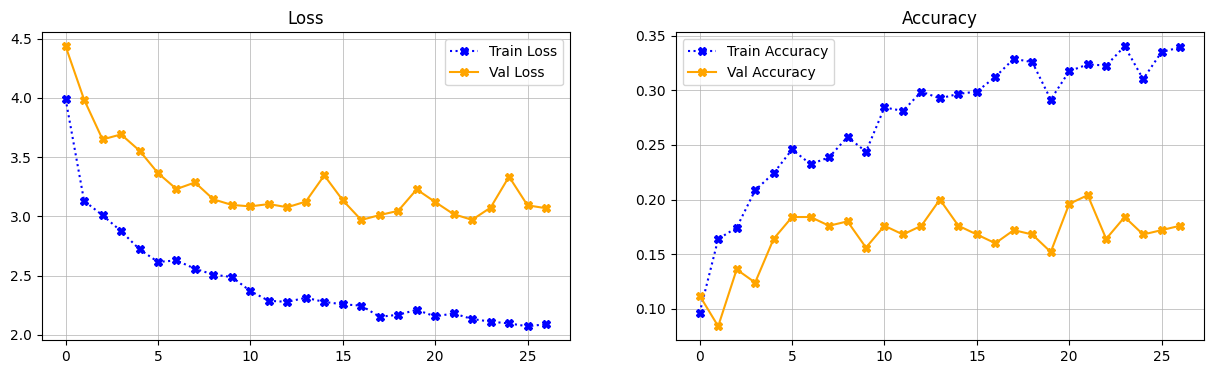

In [102]:
plot_loss_accuracy(history)

### V1 - ResNet 1.3 (pas de vertical flip)

In [103]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import layers, models, callbacks

data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomRotation(0.1),
])

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

base_model.trainable = False

model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),  # Add Batch Normalization
    layers.Dropout(0.6),  # Increased dropout rate
    layers.Dense(18, activation='softmax')
])

initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
)

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    callbacks=[callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')]
)


Epoch 1/200
31/31 [==============================] - 11s 265ms/step - loss: 4.0307 - accuracy: 0.0965 - val_loss: 5.0754 - val_accuracy: 0.0920
Epoch 2/200
31/31 [==============================] - 8s 253ms/step - loss: 3.2136 - accuracy: 0.1598 - val_loss: 3.8130 - val_accuracy: 0.1080
Epoch 3/200
31/31 [==============================] - 7s 236ms/step - loss: 2.9878 - accuracy: 0.1971 - val_loss: 3.5862 - val_accuracy: 0.1760
Epoch 4/200
31/31 [==============================] - 7s 234ms/step - loss: 2.8092 - accuracy: 0.2116 - val_loss: 3.6500 - val_accuracy: 0.1320
Epoch 5/200
31/31 [==============================] - 7s 231ms/step - loss: 2.7518 - accuracy: 0.2054 - val_loss: 3.4056 - val_accuracy: 0.1560
Epoch 6/200
31/31 [==============================] - 7s 232ms/step - loss: 2.5813 - accuracy: 0.2490 - val_loss: 3.4192 - val_accuracy: 0.1520
Epoch 7/200
31/31 [==============================] - 7s 233ms/step - loss: 2.5835 - accuracy: 0.2531 - val_loss: 3.3475 - val_accuracy: 0.144

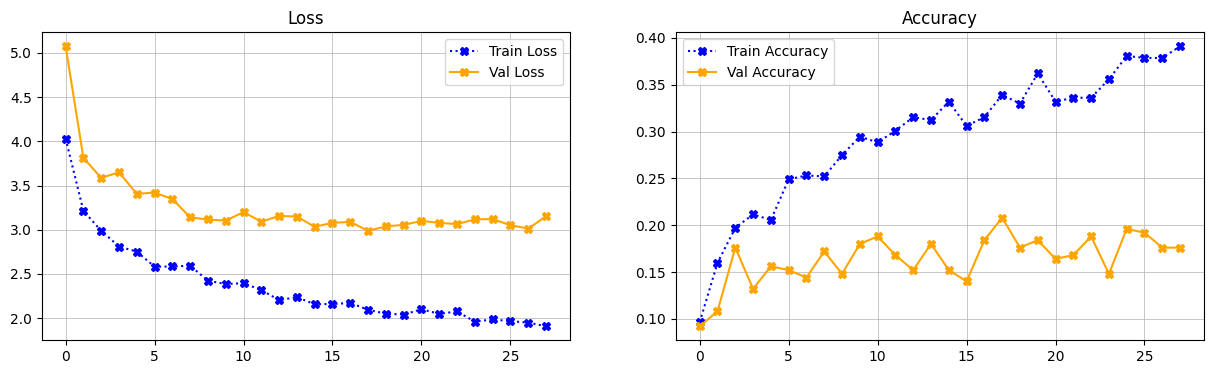

In [104]:
plot_loss_accuracy(history)

### V1 - ResNet 1.4 (reduced data augmentation)

In [108]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import layers, models, callbacks

data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

base_model.trainable = False

model = models.Sequential([
    # data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.6),
    layers.Dense(18, activation='softmax')
])

initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
)

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    callbacks=[callbacks.EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss')]
)


Epoch 1/200
31/31 [==============================] - 9s 246ms/step - loss: 3.8725 - accuracy: 0.0809 - val_loss: 4.9204 - val_accuracy: 0.1000
Epoch 2/200
31/31 [==============================] - 7s 226ms/step - loss: 3.0485 - accuracy: 0.1577 - val_loss: 3.5515 - val_accuracy: 0.0720
Epoch 3/200
31/31 [==============================] - 7s 227ms/step - loss: 2.7732 - accuracy: 0.2230 - val_loss: 3.0898 - val_accuracy: 0.1680
Epoch 4/200
31/31 [==============================] - 7s 219ms/step - loss: 2.6126 - accuracy: 0.2417 - val_loss: 2.8680 - val_accuracy: 0.1680
Epoch 5/200
31/31 [==============================] - 7s 220ms/step - loss: 2.4674 - accuracy: 0.2645 - val_loss: 2.8521 - val_accuracy: 0.1800
Epoch 6/200
31/31 [==============================] - 7s 217ms/step - loss: 2.3454 - accuracy: 0.2790 - val_loss: 2.8670 - val_accuracy: 0.1880
Epoch 7/200
31/31 [==============================] - 7s 218ms/step - loss: 2.2214 - accuracy: 0.3102 - val_loss: 2.8977 - val_accuracy: 0.1880

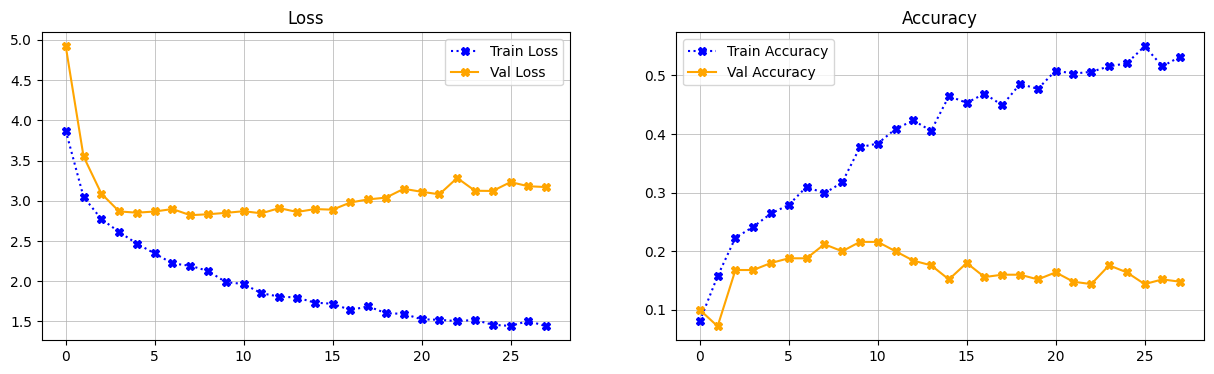

In [109]:
plot_loss_accuracy(history)

### V1 - ResNet 2.0 (Data Augmentation + high Dropout) => best mais overfitting

In [110]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import layers, models, callbacks

data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomRotation(0.1),
])

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

base_model.trainable = False

model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.8),
    layers.Dense(18, activation='softmax')
])

initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
)

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=['accuracy']
)


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    callbacks=[callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')]
)


Epoch 1/200
31/31 [==============================] - 10s 244ms/step - loss: 4.1211 - accuracy: 0.0643 - val_loss: 4.3362 - val_accuracy: 0.0600
Epoch 2/200
31/31 [==============================] - 7s 223ms/step - loss: 3.5520 - accuracy: 0.0778 - val_loss: 3.7796 - val_accuracy: 0.0640
Epoch 3/200
31/31 [==============================] - 7s 223ms/step - loss: 3.4389 - accuracy: 0.0799 - val_loss: 3.3500 - val_accuracy: 0.0680
Epoch 4/200
31/31 [==============================] - 7s 219ms/step - loss: 3.1744 - accuracy: 0.0788 - val_loss: 3.0480 - val_accuracy: 0.1040
Epoch 5/200
31/31 [==============================] - 7s 223ms/step - loss: 3.0978 - accuracy: 0.0871 - val_loss: 2.9502 - val_accuracy: 0.0920
Epoch 6/200
31/31 [==============================] - 7s 224ms/step - loss: 3.0741 - accuracy: 0.1089 - val_loss: 2.8957 - val_accuracy: 0.0880
Epoch 7/200
31/31 [==============================] - 7s 223ms/step - loss: 2.9703 - accuracy: 0.1245 - val_loss: 2.8991 - val_accuracy: 0.116

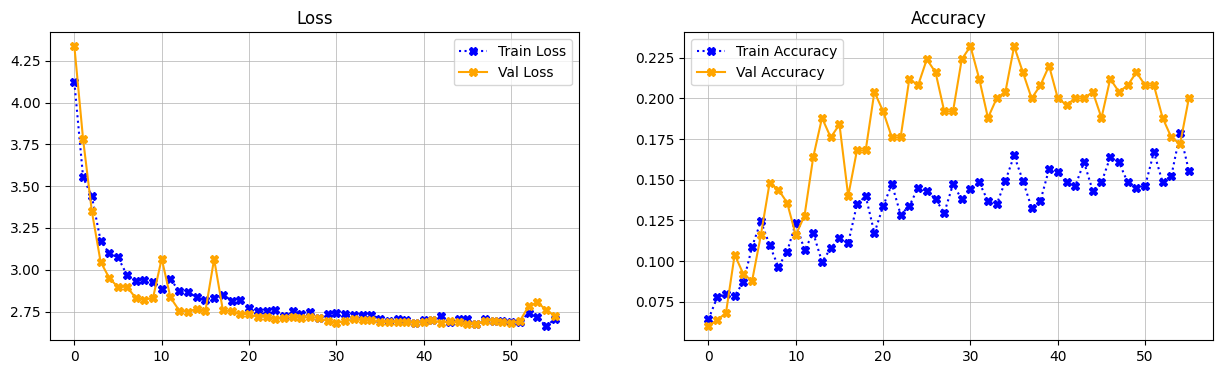

In [112]:
plot_loss_accuracy(history)

In [113]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import layers, models, callbacks

data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomRotation(0.1),
])

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

base_model.trainable = False

model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.8),
    layers.Dense(18, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    callbacks=[callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')]
)


Epoch 1/200
31/31 [==============================] - 10s 251ms/step - loss: 4.3120 - accuracy: 0.0643 - val_loss: 4.8891 - val_accuracy: 0.0400
Epoch 2/200
31/31 [==============================] - 7s 224ms/step - loss: 3.6964 - accuracy: 0.0602 - val_loss: 4.1678 - val_accuracy: 0.0440
Epoch 3/200
31/31 [==============================] - 7s 227ms/step - loss: 3.5324 - accuracy: 0.0892 - val_loss: 3.6564 - val_accuracy: 0.0560
Epoch 4/200
31/31 [==============================] - 7s 220ms/step - loss: 3.3388 - accuracy: 0.1110 - val_loss: 3.4409 - val_accuracy: 0.0760
Epoch 5/200
31/31 [==============================] - 7s 220ms/step - loss: 3.3206 - accuracy: 0.0985 - val_loss: 3.1989 - val_accuracy: 0.0680
Epoch 6/200
31/31 [==============================] - 7s 220ms/step - loss: 3.1707 - accuracy: 0.0954 - val_loss: 3.0391 - val_accuracy: 0.0680
Epoch 7/200
31/31 [==============================] - 7s 221ms/step - loss: 3.1087 - accuracy: 0.1100 - val_loss: 3.0016 - val_accuracy: 0.076

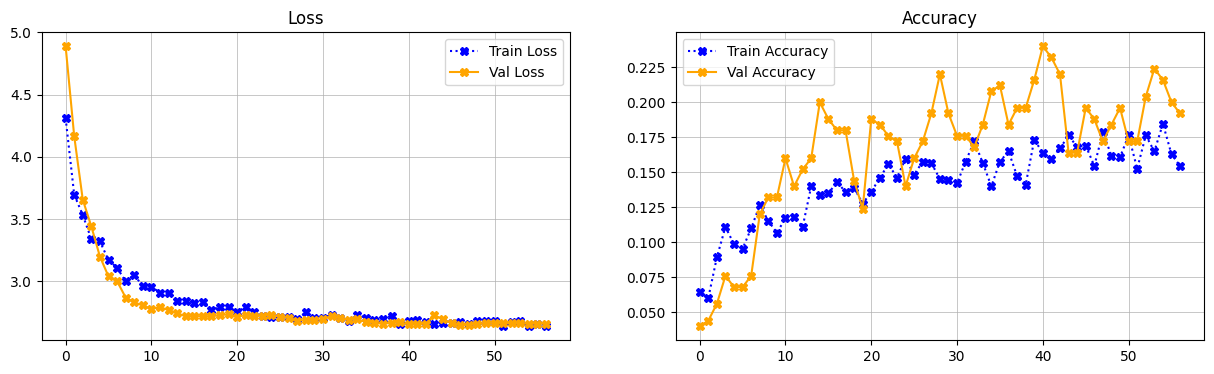

In [114]:
plot_loss_accuracy(history)

In [116]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomRotation(0.1),
])

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

base_model.trainable = False

model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(18, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    callbacks=[callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')]
)


Epoch 1/200
31/31 [==============================] - 11s 249ms/step - loss: 14.5902 - accuracy: 0.0788 - val_loss: 13.4775 - val_accuracy: 0.0800
Epoch 2/200
31/31 [==============================] - 7s 228ms/step - loss: 12.5855 - accuracy: 0.1224 - val_loss: 12.3958 - val_accuracy: 0.1120
Epoch 3/200
31/31 [==============================] - 7s 228ms/step - loss: 11.3295 - accuracy: 0.1421 - val_loss: 11.3938 - val_accuracy: 0.1600
Epoch 4/200
31/31 [==============================] - 7s 228ms/step - loss: 10.3327 - accuracy: 0.1629 - val_loss: 10.2706 - val_accuracy: 0.1320
Epoch 5/200
31/31 [==============================] - 7s 229ms/step - loss: 9.5296 - accuracy: 0.1961 - val_loss: 9.6596 - val_accuracy: 0.1920
Epoch 6/200
31/31 [==============================] - 7s 228ms/step - loss: 8.9056 - accuracy: 0.2023 - val_loss: 8.9275 - val_accuracy: 0.1720
Epoch 7/200
31/31 [==============================] - 7s 224ms/step - loss: 8.4069 - accuracy: 0.1732 - val_loss: 8.3388 - val_accurac

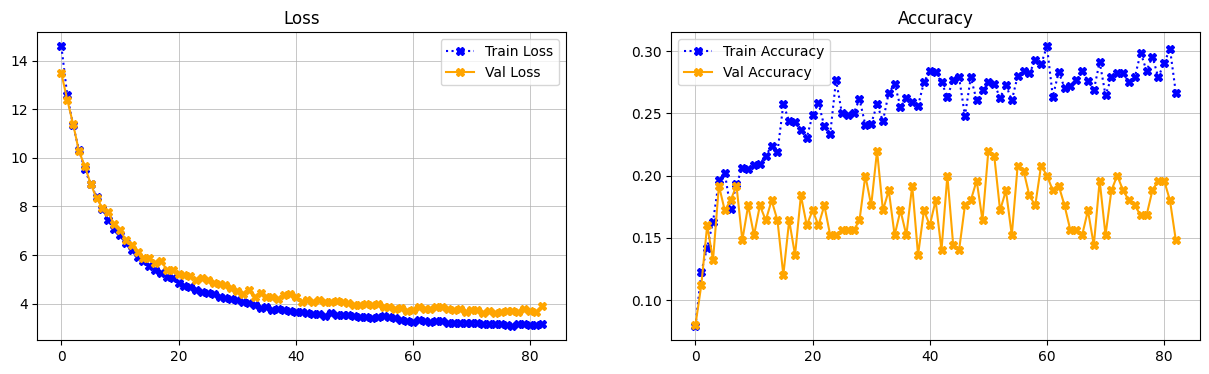

In [117]:
plot_loss_accuracy(history)